<a href="https://colab.research.google.com/github/dpanagop/data_analytics_examples/blob/master/online_retail/Online_retail_Segmentation_by_buying_category.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CUSTOMER SEGMENTAION AND ANALYSIS OF ONLINE RETAIL CUSTOMERS

## Part I - Item Based Segmentation (Segmentation by buying category)

## Introduction
In this notebook we perform customer segmantation of online retail customers based on their spending per product categories. The dataset used is [Online Retail II Data Set](https://archive.ics.uci.edu/ml/datasets/Online+Retail+II) from UC Irvine Machine Learning Repository. Unfortunately the dataset does not contain product categories. Hence we will have to create them. This is done by using `topic modeling on product descriptions`.

## Loading libraries and fetching data


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import openpyxl
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans,MiniBatchKMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from wordcloud import WordCloud
sns.set_style("whitegrid")

In [5]:
online_retail = pd.read_excel('/Users/adityaagarwal/Aditya Ag/Jupyter Notebook/Resume Projects/Customer Segmentation and Analysis of Online Retail/data/online_retail_II.xlsx', sheet_name=None)
online_retail = online_retail['Year 2009-2010'].append(online_retail['Year 2010-2011'],ignore_index=True)

/var/folders/4k/bqkmm_s90gbdmjr_kbd0jv7w0000gn/T/ipykernel_20101/1938153596.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  online_retail = online_retail['Year 2009-2010'].append(online_retail['Year 2010-2011'],ignore_index=True)


Let's take a glimpse of the dataset

In [6]:
print(online_retail.shape)
online_retail.head()

(1067371, 8)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


As we can see, the data set contains Invoice orders that can span multiple rows. Each row represents a specific item and has information on the purchase quantities, price, invoice date, customer ID, and customer country.

In [7]:
online_retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1067371 non-null  object        
 1   StockCode    1067371 non-null  object        
 2   Description  1062989 non-null  object        
 3   Quantity     1067371 non-null  int64         
 4   InvoiceDate  1067371 non-null  datetime64[ns]
 5   Price        1067371 non-null  float64       
 6   Customer ID  824364 non-null   float64       
 7   Country      1067371 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 65.1+ MB


In [8]:
# number of unique customers
print('Number of unique customers: {}'.format(len(online_retail['Customer ID'].unique())))

Number of unique customers: 5943


In [9]:
# number of unique descriptions
print('Number of unique descriptions: {}'.format(len(online_retail['Description'].unique())))

Number of unique descriptions: 5699


In [10]:
online_retail['Description'].value_counts()

WHITE HANGING HEART T-LIGHT HOLDER     5918
REGENCY CAKESTAND 3 TIER               4412
JUMBO BAG RED RETROSPOT                3469
ASSORTED COLOUR BIRD ORNAMENT          2958
PARTY BUNTING                          2765
                                       ... 
IVORY PENDANT SHELL NECKLACE              1
allocate stock for dotcom orders ta       1
PAINTED HEART WREATH WITH BELL            1
FLOWER FAIRY MUG+COASTER,ROSE             1
Zebra invcing error                       1
Name: Description, Length: 5698, dtype: int64

## Item Based Segmentation

To perform an item based segmentation, we will assign each item to specific category. We could perform a segmentation on an item level but rolling up to categories has two benefits:

1. Since there exist 5.699 unique items using them would mean that we would have to work in a high dimensional space (i.e. a 5.699-dimensional space). In general, high dimensional spaces tend to be problematic when clustering (ex. see discussion in “k-Means Advantages and Disadvantages” ).
2. it is easier to describe clusters if we use categories.

## Product categories

Unfortunately, item categories are not available in the dataset. Hence, we must find a way to create them. To do this, we are going to perform clustering on items’ descriptions. We will use k-means clustering (or better a variant of k-means called MiniBatchKMeans). Since k-means works only on `numerical data` we map descriptions to high dimensional vectors. This is done using:

1. `TfidfVectorizer`
2. `Countvectorizer`

The two different methods will allow us to find the better way to model product categories.

### Preprocessing
A little preprocessing is required.
First, we check for missing values in desctiption and replace them with 'NA".

In [11]:
online_retail['Description'].isna().sum()

4382

In [12]:
online_retail['Description'] = online_retail['Description'].fillna('NA')

Then, we
* convert 'Description' column to string (there is a cell wich is integer causing problem latter)
* create a list with unique descriptions

In [13]:
descriptions=online_retail['Description'].apply(str).unique()
print(descriptions.shape)

(5699,)


We would like to remove common words from our analyses. One way to find them is to create a word cloud from all descriptions.

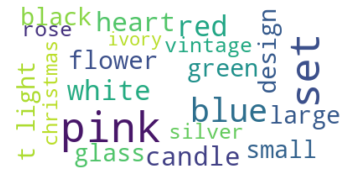

In [16]:
text=[t.lower() for t in descriptions]
#text=text.cat(sep=' ')
#text=text.lower()
text=' '.join([word for word in text])
#text=' '.join([word for word in text.split()])
wordcloud = WordCloud(max_font_size=50, max_words=20, background_color="white",stopwords=ENGLISH_STOP_WORDS).generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Based on the word cloud, we create our stopwords list.

In [24]:
custom_stopwords=ENGLISH_STOP_WORDS.union(['small', 'big','large','light','black', 'red', 'blue', 'green', 'white', 'black', 'pink','glass','ivory', 'metal', 'silver','zinc','set','vintage','design'])

### 1. Using TfidfVectorizer
1. The code below uses TfidfVectorizer to map descriptions to vectors. 
2. Then, it uses MiniBatchKMeans, a variant of k-Means for faster computation to perform clustering for 2, 3,…, 10 clusters. 
3. The results are used to create a graph of sum of squared distances.

Apply TfidfVectorizer on descriptions.

In [25]:
vectorizer = TfidfVectorizer(stop_words=custom_stopwords) # Creating an instance
X_tfidf = vectorizer.fit_transform(descriptions) 
print(X_tfidf.shape)

(5699, 2541)


Use `elbow criterion` for determining number of category clusters.

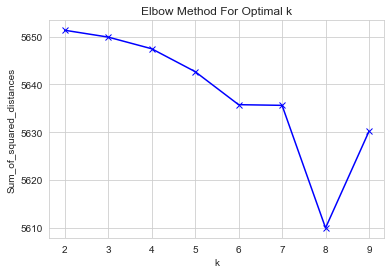

In [27]:
Sum_of_squared_distances = []
K = range(2,10)

for k in K:
    km = MiniBatchKMeans(n_clusters=k, max_iter=4000, n_init=500, random_state=1000) #used insetead KMeans(n_clusters=k, max_iter=4000, n_init=500, random_state=1000, n_jobs= -1) for speed improvement
    km = km.fit(X_tfidf)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

According to the elbow method, the most promising values for the number of clusters are 4, 6, and 8. The code below clusters into 4 groups and then displays a word cloud from the descriptions in each cluster.

Select number of clusters and create a wordcloud of each category cluster.

### A) Taking k = 4

2    5685
1      10
0       3
3       1
Name: category, dtype: int64
Category: 0


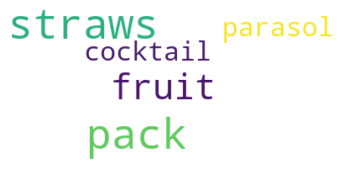

Category: 1


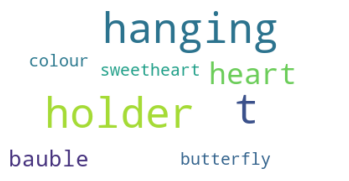

Category: 2


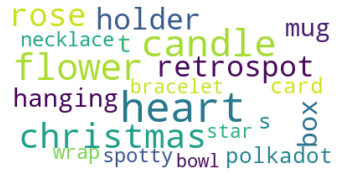

Category: 3


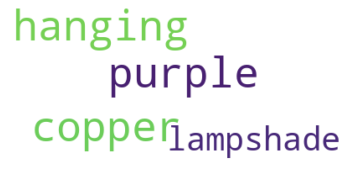

In [30]:
# set number of clusters
true_k = 4
# perform k-means clustering 
model = MiniBatchKMeans(n_clusters=true_k, init='k-means++', max_iter=4000, n_init=500, random_state=1000) 
#KMeans(n_clusters=true_k, init='k-means++', max_iter=4000, n_init=500, random_state=1000)
model.fit(X_tfidf)

# get cluster assignment for each item set
labels=model.labels_
tfidf_description_category=pd.DataFrame(list(zip(descriptions,labels)),columns=['Description','category'])

# print number of items per cluster
print(tfidf_description_category['category'].value_counts())

# create wordclouds for each cluster
for k in range(0,true_k):
    s=tfidf_description_category[tfidf_description_category.category==k]
    text=s['Description'].str.cat(sep=' ')
    text=text.lower()
    text=' '.join([word for word in text.split()])
    wordcloud = WordCloud(max_font_size=50, max_words=20, background_color="white",stopwords=custom_stopwords).generate(text)
    print('Category: {}'.format(k))
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

Seems that:
* category 0 is a quite general,
* category 1 is about bags
* category 2 is about christmas decoration
* category 3 is about other type of decoration

### B) Taking k = 6

4    5655
0      12
2      12
5      11
3       5
1       4
Name: category, dtype: int64
Category: 0


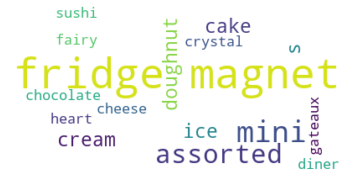

Category: 1


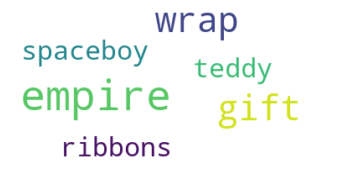

Category: 2


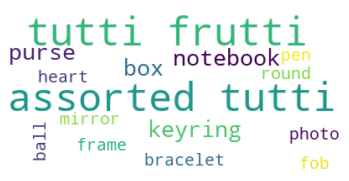

Category: 3


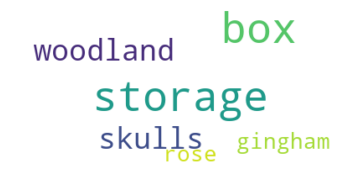

Category: 4


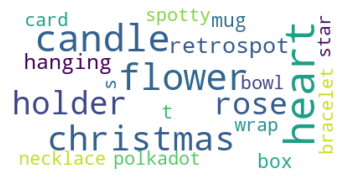

Category: 5


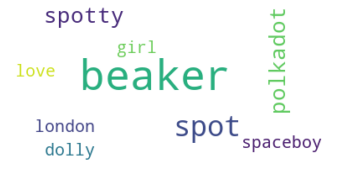

In [31]:
# set number of clusters
true_k = 6
# perform k-means clustering 
model = MiniBatchKMeans(n_clusters=true_k, init='k-means++', max_iter=4000, n_init=500, random_state=1000) 
#KMeans(n_clusters=true_k, init='k-means++', max_iter=4000, n_init=500, random_state=1000)
model.fit(X_tfidf)

# get cluster assignment for each item set
labels=model.labels_
tfidf_description_category=pd.DataFrame(list(zip(descriptions,labels)),columns=['Description','category'])

# print number of items per cluster
print(tfidf_description_category['category'].value_counts())

# create wordclouds for each cluster
for k in range(0,true_k):
    s=tfidf_description_category[tfidf_description_category.category==k]
    text=s['Description'].str.cat(sep=' ')
    text=text.lower()
    text=' '.join([word for word in text.split()])
    wordcloud = WordCloud(max_font_size=50, max_words=20, background_color="white",stopwords=custom_stopwords).generate(text)
    print('Category: {}'.format(k))
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

* category 0 is quite general,
* category 1 is about bags in this case too,
* category 2 is about aromatic candles,
* category 3 is about Christmas decoration,
* category 4 is about other types of decoration,
* category 5 is about cups, bowls, and plates.

### 2. Using CountVectorizer

Apply CountVectorizer on descriptions.

In [32]:
vectorizer = CountVectorizer(stop_words=custom_stopwords) #default stop_words={'english'}
X_countvect = vectorizer.fit_transform(descriptions) 
print(X_countvect.shape)

(5699, 2541)


Use elbow criterion for determining number of category clusters.

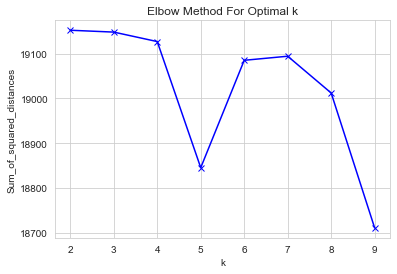

In [33]:
Sum_of_squared_distances = []
K = range(2,10)
for k in K:
    km = MiniBatchKMeans(n_clusters=k, max_iter=4000, n_init=500, random_state=1000) #used insetead KMeans(n_clusters=k, max_iter=4000, n_init=500,  random_state=1000, n_jobs= -1) for speed improvement
    km = km.fit(X_countvect)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Select number of clusters and create a wordcloud of each category cluster.

0    5690
2       6
1       3
Name: category, dtype: int64
Category: 0


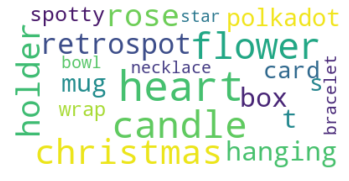

Category: 1


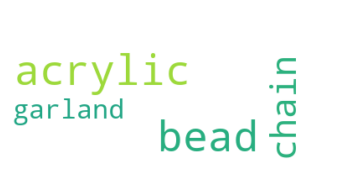

Category: 2


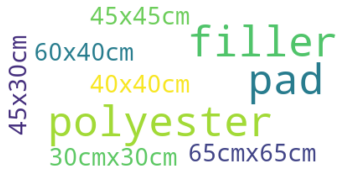

In [34]:
# set number of clusters
true_k = 3
# perform k-means clustering 
model = MiniBatchKMeans(n_clusters=true_k, init='k-means++', max_iter=4000, n_init=500, random_state=100) #KMeans(n_clusters=true_k, init='k-means++', max_iter=4000, n_init=500,  random_state=100)
model.fit(X_countvect)
# get cluster assignment for each item set
labels=model.labels_
countvec_description_category=pd.DataFrame(list(zip(descriptions,labels)),columns=['Description','category'])
# print number of items per cluster
print(countvec_description_category['category'].value_counts())

# create wordclouds for each cluster
for k in range(0,true_k):
    s=countvec_description_category[countvec_description_category.category==k]
    text=s['Description'].str.cat(sep=' ')
    text=text.lower()
    text=' '.join([word for word in text.split()])
    wordcloud = WordCloud(max_font_size=50, max_words=20, background_color="white",stopwords=custom_stopwords).generate(text)
    print('Category: {}'.format(k))
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

It seems that four clusters with TfidfVectorizer are more clear. We are going to use this.

Please note one should **try** using both TfidfVectorizer and CountVectorizer for various number of clusters, complete customer clustering with all of them and then **decide** which to keep.

## Customer Segmentation

In this section we are going to add description categories to the data and use them for customer segmentation.

### FEATURE ENGINEERING - Adding description categories

In [36]:
online_retail_categories= pd.merge(online_retail,tfidf_description_category,on='Description',how='inner')
online_retail_categories.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,category
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,4
1,C489518,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,-1,2009-12-01 11:35:00,7.95,15461.0,United Kingdom,4
2,C489528,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,-1,2009-12-01 11:50:00,7.95,16714.0,United Kingdom,4
3,C489551,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,-1,2009-12-01 12:35:00,6.95,17641.0,United Kingdom,4
4,489559,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 12:55:00,6.95,17056.0,United Kingdom,4


After adding categories, for every row we calculate cost as the product of Quantity by Price.

In [37]:
online_retail_categories['cost']=online_retail_categories['Quantity']*online_retail_categories['Price']
online_retail_categories.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,category,cost
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,4,83.40
1,C489518,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,-1,2009-12-01 11:35:00,7.95,15461.0,United Kingdom,4,-7.95
2,C489528,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,-1,2009-12-01 11:50:00,7.95,16714.0,United Kingdom,4,-7.95
3,C489551,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,-1,2009-12-01 12:35:00,6.95,17641.0,United Kingdom,4,-6.95
4,489559,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 12:55:00,6.95,17056.0,United Kingdom,4,83.40


With this data, we are able to calculate cost per category per month. Note that in category 2 there is a sharp increase on November while it is close to zero during the rest months. This verifies that category 2 has to do with Christmas related products. 

In [46]:
categories_per_date=online_retail_categories
categories_per_date['yearmonth']= online_retail_categories['InvoiceDate'].dt.to_period('M')
categories_per_date=categories_per_date.pivot_table(index=['yearmonth'], 
                    columns='category', 
                    values='cost',
                    margins=True,  # add margins
                    aggfunc='sum').reset_index()
categories_per_date.head()

category,yearmonth,0,1,2,3,4,5,All
0,2009-12,1599.82,413.06,4018.23,1218.61,792595.440,1.95,799847.110
1,2010-01,1457.96,399.84,943.37,339.65,620868.672,23.40,624032.892
2,2010-02,4430.14,322.02,490.15,150.77,527659.346,39.00,533091.426
3,2010-03,753.57,1019.01,678.91,89.30,763249.471,58.50,765848.761
4,2010-04,715.23,454.65,985.31,217.62,588187.812,19.81,590580.432


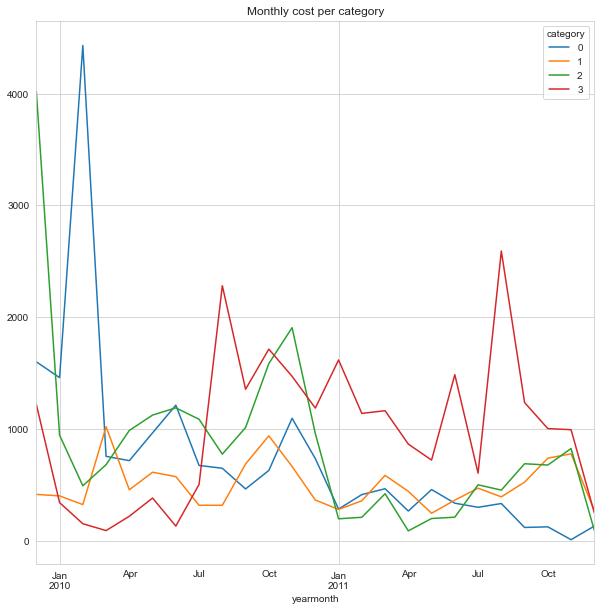

In [39]:
lines=categories_per_date.plot.line(x="yearmonth", y=[0,1,2,3], figsize=(10,10), title='Monthly cost per category')
plt.show()

Next, we calculate total spending (cost) per category for every customer.

In [40]:
customer_spending_per_category=online_retail_categories.pivot_table(index=["Customer ID"], 
                    columns='category', 
                    values='cost',
                   # margins=True,  # add margins
                    aggfunc='sum').reset_index()
customer_spending_per_category.head()

category,Customer ID,0,1,2,3,4,5
0,12346.0,NaN,NaN,NaN,NaN,-64.68,NaN
1,12347.0,NaN,10.5,NaN,NaN,5622.82,NaN
2,12348.0,NaN,NaN,NaN,NaN,2019.40,NaN
3,12349.0,10.2,NaN,NaN,NaN,4394.34,NaN
4,12350.0,NaN,NaN,NaN,NaN,334.40,NaN


In [41]:
customer_spending_per_category=customer_spending_per_category.fillna(0)
customer_spending_per_category.head()

category,Customer ID,0,1,2,3,4,5
0,12346.0,0.0,0.0,0.0,0.0,-64.68,0.0
1,12347.0,0.0,10.5,0.0,0.0,5622.82,0.0
2,12348.0,0.0,0.0,0.0,0.0,2019.40,0.0
3,12349.0,10.2,0.0,0.0,0.0,4394.34,0.0
4,12350.0,0.0,0.0,0.0,0.0,334.40,0.0


In [42]:
customer_spending_per_category.describe()

category,Customer ID,0,1,2,3,4,5
count,5942.000000,5942.000000,5942.000000,5942.000000,5942.000000,5942.000000,5942.000000
mean,15316.500000,2.579532,2.014534,3.005665,3.242790,2786.864199,4.092740
std,1715.451981,58.621366,10.530049,21.003197,43.095855,13894.739602,125.337219
min,12346.000000,-72.000000,0.000000,-20.400000,-8.750000,-25111.090000,-33.110000
25%,13831.250000,0.000000,0.000000,0.000000,0.000000,323.262500,0.000000
50%,15316.500000,0.000000,0.000000,0.000000,0.000000,842.410000,0.000000
75%,16801.750000,0.000000,0.000000,0.000000,0.000000,2169.207500,0.000000
max,18287.000000,4324.560000,333.000000,622.200000,1668.960000,597465.460000,9054.720000


* Finally, we will replace total cost per category with the percentage to the total cost across all categories. 
* Notice, that in some cases, we have negative values. Probably this signifies returns. 
* Since an item that is returned should have been bought in a previous time, we change negative values to positive. 

In [48]:
customer_spending_per_category['total'] = abs(customer_spending_per_category[0])+abs(customer_spending_per_category[1])+abs(customer_spending_per_category[2])+abs(customer_spending_per_category[3])
# if total is 0 reset it to 1, otherwise NaNs will appear when dividing by total
customer_spending_per_category.loc[customer_spending_per_category['total']==0,'total']=1
customer_spending_per_category[0]=abs(customer_spending_per_category[0])/customer_spending_per_category['total']
customer_spending_per_category[1]=abs(customer_spending_per_category[1])/customer_spending_per_category['total']
customer_spending_per_category[2]=abs(customer_spending_per_category[2])/customer_spending_per_category['total']
customer_spending_per_category[3]=abs(customer_spending_per_category[3])/customer_spending_per_category['total']
customer_spending_per_category=customer_spending_per_category.drop(['total'],axis=1)
customer_spending_per_category.fillna(0)
customer_spending_per_category.head()

category,Customer ID,0,1,2,3,4,5
0,12346.0,0.0,0.0,0.0,0.0,-64.68,0.0
1,12347.0,0.0,1.0,0.0,0.0,5622.82,0.0
2,12348.0,0.0,0.0,0.0,0.0,2019.40,0.0
3,12349.0,1.0,0.0,0.0,0.0,4394.34,0.0
4,12350.0,0.0,0.0,0.0,0.0,334.40,0.0


## Customer clustering
This is the section we will create clusters based on the customers

#### k-Means
Generally, We scale the input matrix and use the elbow method to decide the number of customer clusters.

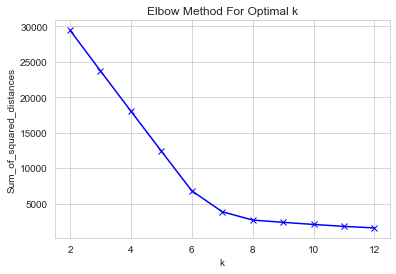

In [50]:
scaler = StandardScaler()
X_std = scaler.fit_transform(customer_spending_per_category.drop(['Customer ID'], axis=1))
Sum_of_squared_distances = []
K = range(2,13)
for k in K:
    km = KMeans(n_clusters=k, max_iter=5000, n_init=500, random_state=100) 
    km = km.fit(X_std)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Remember, that according to the elbow method the `best values for the number of clusters is where there is an elbow/angle in the graph`. Based on this we can select either 4 or 7 as the number of clusters.

##### A) Selecting 7 as the number of clusters.

In [61]:
# set number of clusters
true_k =7
# perform k-means clustering 
model = KMeans(n_clusters=true_k, max_iter=5000, n_init=500, random_state=100) 
model.fit(X_std)
# append cluster assignment for each item set
customer_spending_per_category['cluster']=model.labels_
# print number of items per cluster
print(customer_spending_per_category['cluster'].value_counts())
customer_spending_per_category['cluster']=model.labels_

1    4544
4     430
0     387
6     319
2     255
5       6
3       1
Name: cluster, dtype: int64


Function cluster_profile calculates the median of the spending percentages for each cluster and plots a heatmap with the results.

category Customer ID      0         1         2         3
               count median    median    median    median
cluster                                                  
0                387    0.0  0.000000  1.000000  0.000000
1               4544    0.0  0.000000  0.000000  0.000000
2                255    1.0  0.000000  0.000000  0.000000
3                  1    0.0  0.000000  0.000000  0.000000
4                430    0.0  1.000000  0.000000  0.000000
5                  6    0.0  0.075235  0.013502  0.805787
6                319    0.0  0.000000  0.000000  1.000000




/var/folders/4k/bqkmm_s90gbdmjr_kbd0jv7w0000gn/T/ipykernel_20101/694128340.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  customer_clusters=customer_clusters.drop([('Customer ID', 'count')],1)


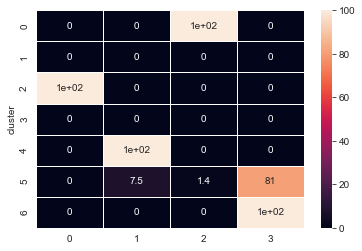

In [62]:
def cluster_profile(customer_spending_per_category):
  ''' profile clusters '''
  customer_clusters=customer_spending_per_category.groupby(['cluster']).agg({'Customer ID':['count'], 
                                                         0:'median',
                                                         1:'median',
                                                         2:'median',
                                                         3:'median'})
  print(customer_clusters)
  print('\n')
  customer_clusters=customer_clusters.drop([('Customer ID', 'count')],1)
  customer_clusters.columns=[0,1,2,3]
  
  customer_clusters[0]=100*customer_clusters[0]
  customer_clusters[1]=100*customer_clusters[1]
  customer_clusters[2]=100*customer_clusters[2]
  customer_clusters[3]=100*customer_clusters[3]
  

  sns.heatmap(customer_clusters, annot=True,  linewidths=.5)

cluster_profile(customer_spending_per_category)

We see that for all clusters there is a high percentage of spending in category 0. In addition:
* cluster 0 has customer with high spending in category 2,
* cluster 1 has high spending only in category 0,
* cluster 2 has customer with high spending in category 3,
* cluster 3 has customer with high spending in category 1.


In [63]:
customer_spending_per_category_k_Means=customer_spending_per_category.copy()

##### Selecting 6 as the number of clusters.

In [65]:
# set number of clusters
true_k = 6
# perform k-means clustering 
model = KMeans(n_clusters=true_k, max_iter=5000, n_init=500, random_state=100,) 
model.fit(X_std)
# append cluster assignment for each item set
customer_spending_per_category['cluster']=model.labels_
# print number of items per cluster
print(customer_spending_per_category['cluster'].value_counts())

1    4544
2     431
3     387
0     322
4     255
5       3
Name: cluster, dtype: int64


category Customer ID      0      1      2         3
               count median median median    median
cluster                                            
0                322    0.0    0.0    0.0  1.000000
1               4544    0.0    0.0    0.0  0.000000
2                431    0.0    1.0    0.0  0.000000
3                387    0.0    0.0    1.0  0.000000
4                255    1.0    0.0    0.0  0.000000
5                  3    0.0    0.0    0.0  0.696438




/var/folders/4k/bqkmm_s90gbdmjr_kbd0jv7w0000gn/T/ipykernel_20101/694128340.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  customer_clusters=customer_clusters.drop([('Customer ID', 'count')],1)


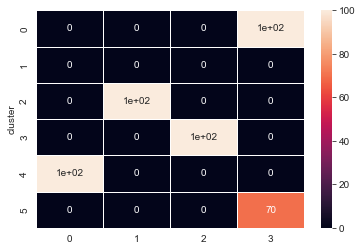

In [66]:
cluster_profile(customer_spending_per_category)

We see that we get clusters with higher percentage in category 1 or category 2 than category 0.

#### Hierachical clustering
Using hierachical clustering we can gain a better understanding of the possible number of clusters.

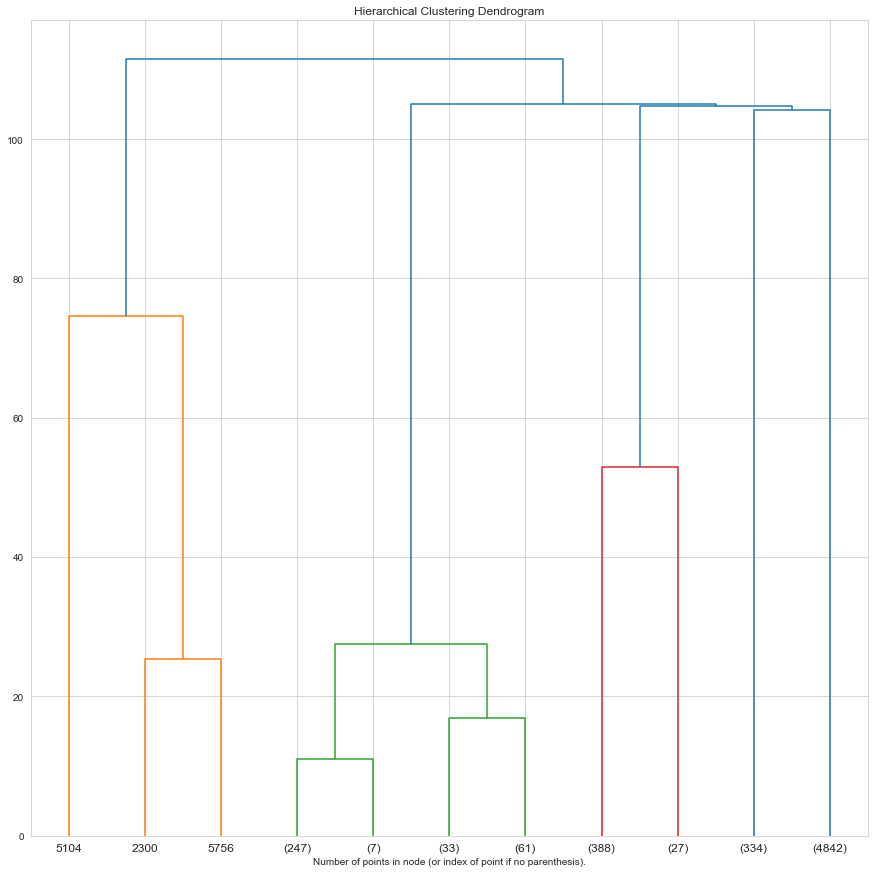

In [67]:
# source https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)



# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None,linkage='ward')

model = model.fit(X_std)
plt.figure(figsize=(15,15))
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

##### Selecting 4 as the number of clusters.

In [33]:
model = AgglomerativeClustering(n_clusters=4,linkage='ward')
model.fit(X_std)
# append cluster assignment for each item set
customer_spending_per_category['cluster']=model.labels_
# print number of items per cluster
print(customer_spending_per_category['cluster'].value_counts())

0    4414
3    1023
1     348
2     157
Name: cluster, dtype: int64


        Customer ID         0         1         2         3
              count    median    median    median    median
cluster                                                    
0              4414  0.889064  0.021330  0.000708  0.029781
1               348  0.676525  0.007130  0.243169  0.022549
2               157  0.319656  0.643302  0.000000  0.000000
3              1023  0.697939  0.001869  0.024104  0.215819




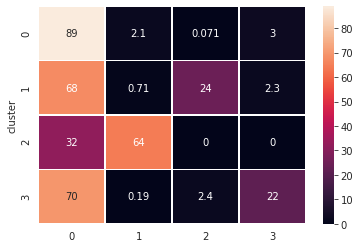

In [34]:
cluster_profile(customer_spending_per_category)

We observe that, now, the cluster with high spending in category 1 (cluster 3) has higher spending in category 1 than in category 0. This inversion is a result its smaller size. 

We will store the results of k-means clustering into 4 clusters.

In [35]:
customer_spending_per_category_k_Means.to_pickle('customer_segments_buying_categories.pickle')
# load with
# customer_spending_per_category = pd.read_pickle(file_name)

In [36]:
from google.colab import files
files.download('customer_segments_buying_categories.pickle') 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>